In [1]:
import pandas as pd
import tensorflow.keras.layers as Layer
from tensorflow.keras import optimizers, Sequential, Model
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller 
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


c:\Users\HP\OneDrive\Desktop\Tenx\Forecast_Financial_Data\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\HP\OneDrive\Desktop\Tenx\Forecast_Financial_Data\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\HP\OneDrive\Desktop\Tenx\Forecast_Financial_Data\venv\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at

Upload the data

In [2]:
df = pd.read_csv("../data/TSLA_10years_data.csv")
scaler = MinMaxScaler() 
df["Close"]  =  scaler.fit_transform(df[["Close"]]) 
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
data = df["Close"]

Split the data

In [3]:
train_data_length = len(data[data.index < pd.Timestamp('2024-01-01' ,  tz='UTC')])
print(train_data_length)

2113


In [4]:
def create_sequences(data, window=60):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

In [5]:
X , y = create_sequences(data, window=120)

In [6]:
X, y = np.array(X), np.array(y)
print(f"X shape{X.shape} , y shape { y.shape}")

X shape(2395, 120) , y shape (2395,)


In [7]:
X_train = X[:train_data_length]
y_train =  y[:train_data_length]
X_test  =  X[train_data_length:]
y_test  =  y[train_data_length:] 

# Regular LSTM

In [8]:

epochs = 50
batch = 32
lr = 0.0001
lstm_model = Sequential()
lstm_model.add(Layer.LSTM(50, input_shape=( 120, 1), return_sequences=True))
lstm_model.add(Layer.LSTM(25, activation='tanh', return_sequences=True))
lstm_model.add(Layer.LSTM(10, activation='tanh'))
lstm_model.add(Layer.Dense(1))
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 120, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 120, 25)        │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 10)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,451 (75.98 KB)

 Trainable params: 19,451 (75.98 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
cp1 = ModelCheckpoint('/kaggle/working/model.keras', save_best_only=True)

lstm_model.compile(loss=MeanSquaredError(), optimizer=optimizers.Adam(learning_rate=lr), metrics=[RootMeanSquaredError()])

In [10]:
lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch, validation_split=0.1 , verbose=1 )

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 39s 289ms/step - loss: 0.0462 - root_mean_squared_error: 0.2150 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0886
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 241ms/step - loss: 0.0052 - root_mean_squared_error: 0.0724 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0438
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0024 - root_mean_squared_error: 0.0491 - val_loss: 0.0022 - val_root_mean_squared_error: 0.0468
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - loss: 0.0021 - root_mean_squared_error: 0.0463 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0447
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - loss: 0.0020 - root_mean_squared_error: 0.0449 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0433
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - loss: 0.0019 - root_mean_squared_error: 0.0434 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/ste

In [11]:
lstm_model.evaluate(X_train, y_train)

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 6.8986e-04 - root_mean_squared_error: 0.0263


[0.0006898572901263833, 0.026265135034918785]

In [12]:
Predicted = lstm_model.predict(X_test)
Actual = y_test

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step


In [13]:
print("Actual Shape:", Actual.shape)
print("Predicted Shape:", Predicted.shape)

Actual Shape: (282,)
Predicted Shape: (282, 1)


In [14]:
Actual = Actual.reshape(-1)
Predicted = Predicted.reshape(-1)

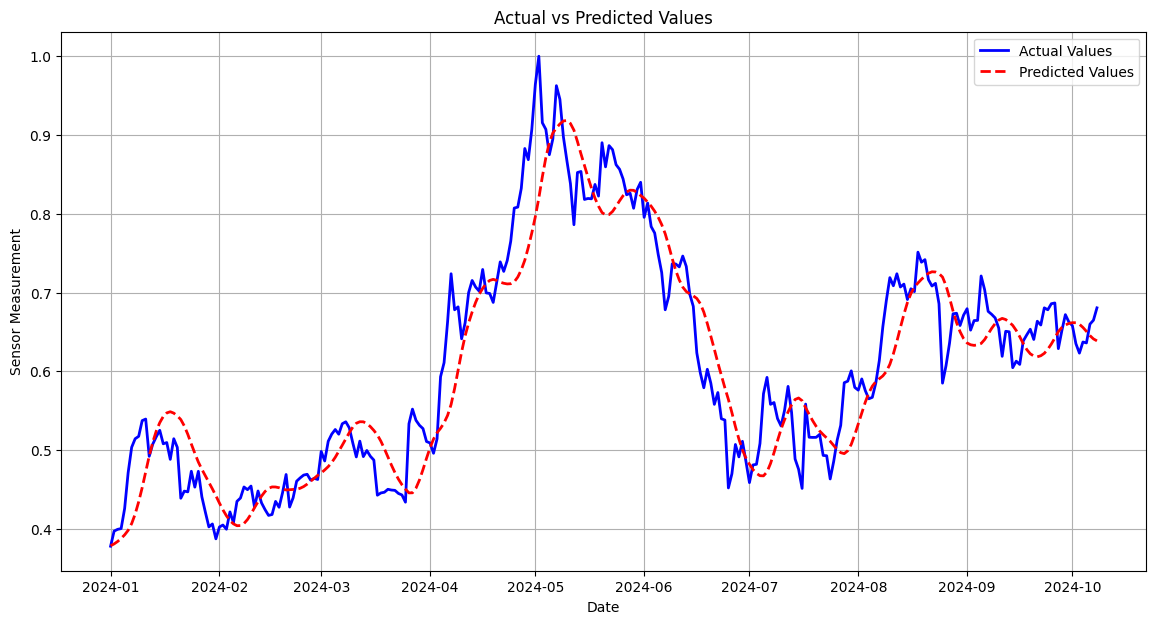

In [15]:
date_range = pd.date_range(start='2024-01-01', periods=len(Actual), freq='D')
plt.figure(figsize=(14, 7))
plt.plot(date_range, Actual, label='Actual Values', color='blue', linewidth=2)
plt.plot(date_range, Predicted, label='Predicted Values', color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Sensor Measurement')
plt.legend()
plt.grid()

plt.show()

In [16]:
Predicted.shape

(282,)

# Evaluate

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mae_lstm = mean_absolute_error(Actual, Predicted)
rmse_lstm = np.sqrt(mean_squared_error(Actual, Predicted))
mape_lstm = mean_absolute_percentage_error(Actual, Predicted)


print("LSTM Performance:")
print(f"MAE: {mae_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAPE: {mape_lstm:.2f}%")

LSTM Performance:
MAE: 0.0400
RMSE: 0.0524
MAPE: 6.68%


* Save the  model

In [18]:
import pickle

with open('../model/lstm_model.pkl', 'wb') as f:
    pickle.dump(lstm_model, f)